In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


def set_all_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
seed = 0
set_all_seed(seed=seed)

Using device: cuda


In [2]:
# Paths
# TRAIN_DIR = './cosmic-curator/train_images'
# TEST_DIR = './cosmic-curator/test_images'
# TRAIN_CSV = './cosmic-curator/train2.csv'

TRAIN_DIR = '/kaggle/input/cosmic-curator/train_images/train_images'
TEST_DIR = '/kaggle/input/cosmic-curator/test_images/test_images'
TRAIN_CSV = '/kaggle/input/cosmic-curator/train3.csv'
OUT_DIR = './results'
if os.path.exists(OUT_DIR):
    import shutil
    shutil.rmtree(OUT_DIR)
# create directory
os.makedirs(OUT_DIR, exist_ok=True)
OUT_TRAIN_CSV = os.path.join(OUT_DIR, 'train.csv')
OUT_TEST_CSV = os.path.join(OUT_DIR, 'test.csv')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
# BATCH_SIZE = 32
BATCH_SIZE = 16
NUM_CLASSES = 3
NUM_EPOCHS = 50
LEARNING_RATE = 3e-5
IMG_SIZE = 424
VAL_SPLIT = 0.2
SAVE_CHECKPOINT = True

In [3]:
# --- Custom Dataset ---
class GalaxyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        asset_id = self.df.loc[idx, 'asset_id']
        img_path = os.path.join(self.img_dir, f"{asset_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, asset_id
        else:
            label = int(self.df.loc[idx, 'GalaxyType'])
            return image, label

# --- Transforms ---
# train_transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

weights = models.Swin_T_Weights.DEFAULT
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [4]:
# --- Load CSV ---
train_df = pd.read_csv(TRAIN_CSV)
print("Images in train set:", len(train_df))
# delete the images that are not in the train set
train_img_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TRAIN_DIR) if f.endswith('.jpg')]
train_df = train_df[train_df['asset_id'].isin(train_img_asset_ids)]
train_df = train_df.reset_index(drop=True)

test_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TEST_DIR) if f.endswith('.jpg')]
test_df = pd.DataFrame({'asset_id': test_asset_ids})
print("Images in test set:", len(test_df))


# --- Train/Val Split ---
train_df, val_df = train_test_split(train_df, test_size=VAL_SPLIT, stratify=train_df['GalaxyType'], random_state=seed)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("After splitting into train and val sets:")
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Images in train set: 911
Images in test set: 412
After splitting into train and val sets:
Train size: 727
Val size: 182
Test size: 412


In [5]:
# class counts
print("Train class counts:")
print(train_df['GalaxyType'].value_counts())
print("Val class counts:")
print(val_df['GalaxyType'].value_counts())

Train class counts:
GalaxyType
2    397
0    219
1    111
Name: count, dtype: int64
Val class counts:
GalaxyType
2    99
0    55
1    28
Name: count, dtype: int64


In [6]:
train_dataset = GalaxyDataset(train_df, TRAIN_DIR, transform=train_transform)
val_dataset = GalaxyDataset(val_df, TRAIN_DIR, transform=test_transform)
test_dataset = GalaxyDataset(test_df, TEST_DIR, transform=test_transform, is_test=True)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset)) 
print("Test dataset size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train dataset size: 727
Validation dataset size: 182
Test dataset size: 412
Train loader size: 46
Validation loader size: 12
Test loader size: 26


In [7]:
# --- Model ---
# # model = models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 3)
# )

weights = models.Swin_T_Weights.DEFAULT
model = models.swin_t(weights=weights)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 206MB/s] 


In [8]:
# --- Training Loop ---
# Initialize lists to store F1 scores
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []

best_val_f1 = 0.0  # To track the best validation F1 score
best_model_path = os.path.join(OUT_DIR, 'best_model.pth')

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(train_labels, train_preds, average='macro')
    train_f1_scores.append(train_f1)
    train_losses.append(train_loss / len(train_loader))  # Average train loss

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_losses.append(val_loss / len(val_loader))  # Average validation loss

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train F1={train_f1:.4f}, Val Loss={val_losses[-1]:.4f}, Val F1={val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with Val F1={best_val_f1:.4f}")

    # Save checkpoint for each epoch if enabled
    # if SAVE_CHECKPOINT and (epoch + 1) % 5 == 0:
    if SAVE_CHECKPOINT:
        checkpoint_path = os.path.join(OUT_DIR, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)

Epoch 1 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


Epoch 1: Train Loss=0.9361, Train F1=0.3169, Val Loss=0.8311, Val F1=0.4288
✅ Best model saved with Val F1=0.4288


Epoch 2 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


Epoch 2: Train Loss=0.7810, Train F1=0.5169, Val Loss=0.6223, Val F1=0.6644
✅ Best model saved with Val F1=0.6644


Epoch 3 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]


Epoch 3: Train Loss=0.6718, Train F1=0.6550, Val Loss=0.6579, Val F1=0.6464


Epoch 4 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]


Epoch 4: Train Loss=0.5972, Train F1=0.6838, Val Loss=0.5754, Val F1=0.7340
✅ Best model saved with Val F1=0.7340


Epoch 5 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


Epoch 5: Train Loss=0.5785, Train F1=0.7086, Val Loss=0.6006, Val F1=0.6735


Epoch 6 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


Epoch 6: Train Loss=0.5385, Train F1=0.7320, Val Loss=0.6411, Val F1=0.7142


Epoch 7 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch 7: Train Loss=0.5299, Train F1=0.7277, Val Loss=0.7046, Val F1=0.6368


Epoch 8 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


Epoch 8: Train Loss=0.4875, Train F1=0.7552, Val Loss=0.6447, Val F1=0.6938


Epoch 9 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]


Epoch 9: Train Loss=0.5017, Train F1=0.7546, Val Loss=0.6081, Val F1=0.7443
✅ Best model saved with Val F1=0.7443


Epoch 10 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s]


Epoch 10: Train Loss=0.4741, Train F1=0.7625, Val Loss=0.6625, Val F1=0.7094


Epoch 11 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.69it/s]


Epoch 11: Train Loss=0.4587, Train F1=0.7533, Val Loss=0.6566, Val F1=0.6894


Epoch 12 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s]


Epoch 12: Train Loss=0.4363, Train F1=0.7703, Val Loss=0.5996, Val F1=0.7903
✅ Best model saved with Val F1=0.7903


Epoch 13 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.77it/s]


Epoch 13: Train Loss=0.4045, Train F1=0.8034, Val Loss=0.8059, Val F1=0.6655


Epoch 14 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 14: Train Loss=0.4263, Train F1=0.7888, Val Loss=0.6710, Val F1=0.6979


Epoch 15 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]


Epoch 15: Train Loss=0.3807, Train F1=0.8031, Val Loss=0.7266, Val F1=0.6800


Epoch 16 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s]


Epoch 16: Train Loss=0.3566, Train F1=0.8262, Val Loss=0.6920, Val F1=0.7146


Epoch 17 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s]


Epoch 17: Train Loss=0.3356, Train F1=0.8302, Val Loss=0.7184, Val F1=0.7049


Epoch 18 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]


Epoch 18: Train Loss=0.2882, Train F1=0.8560, Val Loss=0.8780, Val F1=0.7044


Epoch 19 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


Epoch 19: Train Loss=0.3004, Train F1=0.8711, Val Loss=0.8347, Val F1=0.7206


Epoch 20 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]


Epoch 20: Train Loss=0.3418, Train F1=0.8460, Val Loss=0.7249, Val F1=0.6974


Epoch 21 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.69it/s]


Epoch 21: Train Loss=0.2610, Train F1=0.8754, Val Loss=0.8253, Val F1=0.7387


Epoch 22 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 22: Train Loss=0.2641, Train F1=0.8667, Val Loss=0.8736, Val F1=0.7331


Epoch 23 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


Epoch 23: Train Loss=0.2569, Train F1=0.8612, Val Loss=0.8451, Val F1=0.7411


Epoch 24 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch 24: Train Loss=0.2354, Train F1=0.8853, Val Loss=0.7671, Val F1=0.7418


Epoch 25 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch 25: Train Loss=0.2161, Train F1=0.9071, Val Loss=0.8417, Val F1=0.7257


Epoch 26 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]


Epoch 26: Train Loss=0.2240, Train F1=0.8958, Val Loss=0.8556, Val F1=0.7055


Epoch 27 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


Epoch 27: Train Loss=0.1914, Train F1=0.9176, Val Loss=0.8379, Val F1=0.7498


Epoch 28 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


Epoch 28: Train Loss=0.1700, Train F1=0.9182, Val Loss=0.9366, Val F1=0.7272


Epoch 29 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


Epoch 29: Train Loss=0.2371, Train F1=0.8908, Val Loss=0.9883, Val F1=0.6887


Epoch 30 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


Epoch 30: Train Loss=0.1831, Train F1=0.9197, Val Loss=0.8409, Val F1=0.7514


Epoch 31 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]


Epoch 31: Train Loss=0.1505, Train F1=0.9395, Val Loss=1.0445, Val F1=0.7413


Epoch 32 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.73it/s]


Epoch 32: Train Loss=0.1656, Train F1=0.9308, Val Loss=1.0198, Val F1=0.7305


Epoch 33 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s]


Epoch 33: Train Loss=0.1553, Train F1=0.9262, Val Loss=1.2268, Val F1=0.6884


Epoch 34 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


Epoch 34: Train Loss=0.1149, Train F1=0.9455, Val Loss=0.9976, Val F1=0.7293


Epoch 35 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 35: Train Loss=0.1318, Train F1=0.9459, Val Loss=1.5892, Val F1=0.6304


Epoch 36 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 36: Train Loss=0.1372, Train F1=0.9468, Val Loss=1.6339, Val F1=0.6215


Epoch 37 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s]


Epoch 37: Train Loss=0.1937, Train F1=0.9212, Val Loss=1.5688, Val F1=0.6718


Epoch 38 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 38: Train Loss=0.1670, Train F1=0.9399, Val Loss=0.9750, Val F1=0.7478


Epoch 39 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 39: Train Loss=0.1140, Train F1=0.9485, Val Loss=1.0433, Val F1=0.7542


Epoch 40 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]


Epoch 40: Train Loss=0.1349, Train F1=0.9460, Val Loss=1.1029, Val F1=0.6687


Epoch 41 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


Epoch 41: Train Loss=0.1204, Train F1=0.9460, Val Loss=1.0369, Val F1=0.6949


Epoch 42 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


Epoch 42: Train Loss=0.0912, Train F1=0.9628, Val Loss=1.1647, Val F1=0.7254


Epoch 43 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.58it/s]


Epoch 43: Train Loss=0.0770, Train F1=0.9767, Val Loss=1.1020, Val F1=0.7233


Epoch 44 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch 44: Train Loss=0.0869, Train F1=0.9675, Val Loss=1.3172, Val F1=0.7083


Epoch 45 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


Epoch 45: Train Loss=0.0719, Train F1=0.9767, Val Loss=1.3532, Val F1=0.7271


Epoch 46 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


Epoch 46: Train Loss=0.0976, Train F1=0.9563, Val Loss=1.2041, Val F1=0.7625


Epoch 47 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch 47: Train Loss=0.1115, Train F1=0.9476, Val Loss=1.1041, Val F1=0.7791


Epoch 48 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch 48: Train Loss=0.0897, Train F1=0.9596, Val Loss=1.1371, Val F1=0.7304


Epoch 49 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.69it/s]


Epoch 49: Train Loss=0.0574, Train F1=0.9781, Val Loss=1.4629, Val F1=0.7275


Epoch 50 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]


Epoch 50: Train Loss=0.0482, Train F1=0.9791, Val Loss=1.7479, Val F1=0.6625


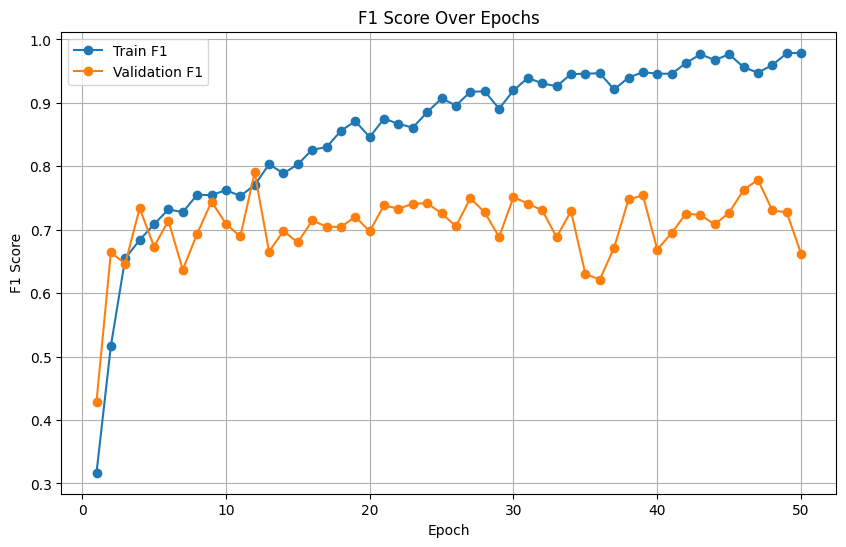

✅ F1 score plot saved at ./results/f1_scores_plot.png


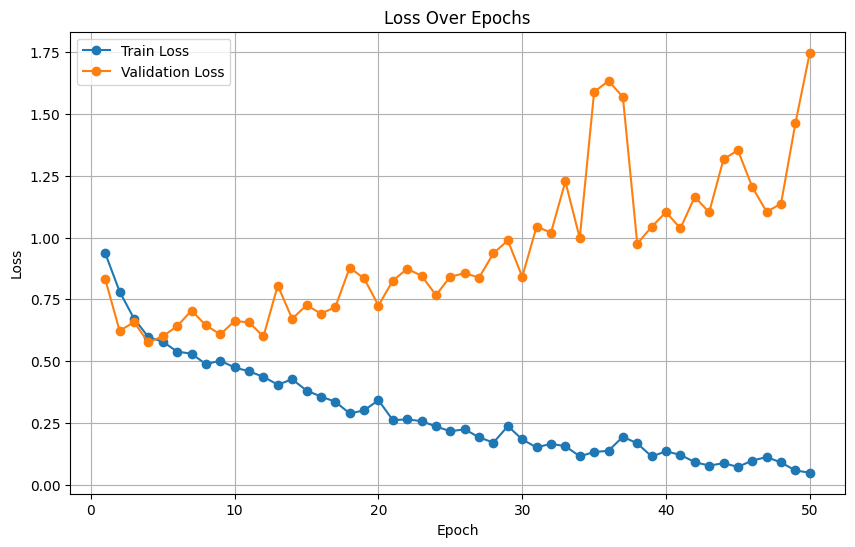

✅ Loss plot saved at ./results/losses_plot.png


In [10]:
# --- Plot F1 Scores ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores, label='Train F1', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_f1_scores, label='Validation F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'f1_scores_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ F1 score plot saved at {plot_path}")

# --- Plot Losses ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'losses_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ Loss plot saved at {plot_path}")

In [20]:
# load best model
# model = models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 3)
# )

model = models.swin_t(weights=weights)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(DEVICE)
best_model_path = os.path.join(OUT_DIR, 'model_epoch_4.pth')
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model = model.to(DEVICE)

In [21]:
# --- Test Prediction ---
model.eval()
predictions = []
asset_ids = []

with torch.no_grad():
    for images, ids in tqdm(test_loader, desc="Predicting"):
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        predictions.extend(preds)
        asset_ids.extend(ids.cpu().numpy())  # Convert tensor to numpy array and extend

# --- Save Submission ---
submission_df = pd.DataFrame({'id': asset_ids, 'GalaxyType': predictions})
submission_df.sort_values('id', inplace=True)
submission_df.to_csv(OUT_TEST_CSV, index=False)
print(f"Submission saved to {OUT_TEST_CSV}")
print(submission_df.head())


Predicting: 100%|██████████| 26/26 [00:05<00:00,  4.78it/s]

Submission saved to ./results/test.csv
     id  GalaxyType
133   1           2
398   2           0
348   3           2
336   4           2
35    5           0
